In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.nn import functional as F

from sklearn.metrics import accuracy_score

In [2]:
DATA_PATH = '../data/'

In [4]:
df = pd.read_csv(f'{DATA_PATH}4m-oYYqjRvqVvyu2ryjmSw_common_words_100_final_data.csv')

In [5]:
df.head()

,actual_words,act,activity,alter,assemblage,be,change,cover,form,give,...,POS_TAG_ADV,POS_TAG_AUX,POS_TAG_CCONJ,POS_TAG_INTJ,POS_TAG_NOUN,POS_TAG_NUM,POS_TAG_PROPN,POS_TAG_SCONJ,POS_TAG_VERB,POS_TAG_X
0,abbreviation,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,ablate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,abduction,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,ability,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,abound,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
from gensim.models import KeyedVectors


def _load_word_embedding_model(file=f'../models/fasttext/crawl-300d-2M-subword.vec', word_embedding_type="fasttext"):
    model = {}
    if file is None:
        file, *ign = embeddings.get("GLOVE_6B_300D")
    print("Loading Model")
    if word_embedding_type == "glove":
        df = pd.read_csv(file, sep=" ", quoting=3, header=None, index_col=0)
        model = {key: val.values for key, val in df.T.items()}
        print(len(model), " words loaded!")
    elif word_embedding_type == "word2vec":
        model = KeyedVectors.load_word2vec_format(file, binary=True)
    elif word_embedding_type == "fasttext":
        model = KeyedVectors.load_word2vec_format(file, binary=False)
    return model
MODEL = _load_word_embedding_model()

Loading Model


In [58]:
def _get_word_embeddings(word):
    try:
        return MODEL[word]
    except Exception as e:
        return None

In [59]:
df['Embedding'] = df["actual_words"].apply(_get_word_embeddings)

In [60]:
df.dropna(inplace=True)

In [61]:
x_data = df.loc[:, df.columns == 'Embedding']
y_data = df.loc[:, df.columns == 'activity']

In [62]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(s_df):
    device = get_device()
    return Variable(torch.Tensor(s_df.values)).to(device)

def complex_df_to_tensor(_df):
    device = get_device()
    temp_x = []
    for index, row in _df.iterrows():
        temp_row = []
        row = row.to_dict()
        g_em = []
        for key in row.keys():
            if key != 'Embedding':
                temp_row.append(row[key])
            else:
                g_em = Variable(torch.Tensor(row[key])).to(device)
        temp_x.append(torch.cat([
            Variable(torch.Tensor(temp_row)).to(device), 
            g_em]
            ,dim=0))

    return torch.stack(temp_x, 0)

In [63]:
y_data = df_to_tensor(y_data)
x_data = complex_df_to_tensor(x_data)

In [51]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
model = LogisticRegression(300, 1)

In [64]:
class SingleLayeredNN(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_dim: int):
        super(SingleLayeredNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_dim)
        self.sigmoid2 = torch.nn.Sigmoid()

    def forward(self, x):
        hidden = self.fc1(x)
        sigmoid = self.sigmoid1(hidden)
        output = self.fc2(sigmoid)
        output = self.sigmoid2(output)
        return output
model = SingleLayeredNN(300, 300, 1)

In [65]:
criterion = torch.nn.BCELoss(reduction='mean')

In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

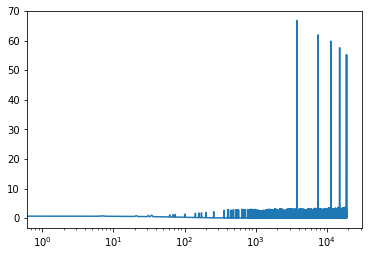

In [67]:
model.cuda()

train_loss = []
for epoch in range(5):
    running_loss = 0.0
    for data in zip(x_data, y_data):
        x, y = data
        model.train()
        # Forward pass
        y_pred = model(x)
         # Compute Loss
        loss = criterion(y_pred, y)

        train_loss.append(loss.item())

        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item() * x.size(0)
        
    epoch_loss = running_loss / len(x_data)
    train_loss.append(epoch_loss)

plt.plot(train_loss)
plt.xscale('log')

In [31]:
y_pred = model(x_data)

In [32]:
y_data = y_data.cpu().detach().numpy() 
x_data = x_data.cpu().detach().numpy() 
y_pred = y_pred.cpu().detach().numpy() 

In [33]:
y_pred_labels = []
for p in y_pred:
    if p < 0.5:
        label = 0
    else:
        label = 1
    y_pred_labels.append(label)

In [34]:
accuracy_score(y_data, y_pred_labels)

0.9443413729128015

In [35]:
from sklearn.metrics import f1_score

f1_score = f1_score(y_data, y_pred_labels, average='micro')

print(f1_score)

0.9443413729128015


In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_data, y_pred)

0.7442083316627239

In [37]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_data, y_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.7442083316627239

Text(0, 0.5, 'True Positive Rate')

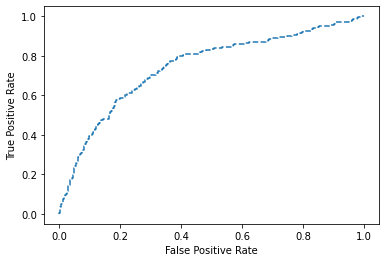

In [38]:
from matplotlib import pyplot

pyplot.plot(fpr, tpr, linestyle='--', label='Move')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

In [39]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_data, y_pred)

Text(0, 0.5, 'Precision')

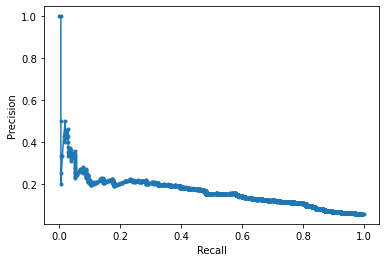

In [40]:
pyplot.plot(recall, precision, marker='.', label='move')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')